In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from scipy import interpolate

np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
nnpz_output = fits.open('/home/aalvarez/Work/Data/DC2/nnpz_dc2_output.fits')

In [3]:
table = nnpz_output[1].data
pdz_bins = nnpz_output[2].data['BINS_PDF']
pdz=table['REDSHIFT_PDF']
out_pdz_bins = pdz_bins[range(1, len(pdz_bins), 2)]

## Calculate median and mode of a function

In [4]:
def mode(bins, pdfs):
    return bins[np.argmax(pdfs, axis=1)]

In [5]:
def median(bins, pdfs):
    medians = np.zeros((len(pdfs),))
    for i in range(len(pdfs)):
        cum_prob = np.zeros(len(bins))
        cum_prob[1:] = np.cumsum(np.diff(bins) * ((pdfs[i, :-1] + pdfs[i, 1:]) / 2.))
        inv_cum = interpolate.interp1d(cum_prob/max(cum_prob), bins, kind='linear')
        medians[i] = inv_cum(0.5)
    return medians

## Plot comparative

In [32]:
def plot_pdz(original, recomputed):
    original_median = median(pdz_bins, np.expand_dims(original,axis=0))
    original_mode = mode(pdz_bins, np.expand_dims(original,axis=0))
    
    out_median = median(out_pdz_bins, np.expand_dims(recomputed,axis=0))
    out_mode = mode(out_pdz_bins, np.expand_dims(recomputed,axis=0))
    
    plt.figure(figsize=(24,8))
    plt.bar(pdz_bins, original, width=0.01)
    plt.bar(out_pdz_bins, recomputed, alpha=0.5, width=0.02)
    
    top = np.max(original)
    
    plt.plot([original_median, original_median], [0., top], '--', color='green', label='Original median')
    plt.plot([out_median, out_median], [0., top], '-.', color='pink', label='Output median')
    
    plt.plot([original_mode, original_mode], [0., top], '--', color='red', label='Original mode')   
    plt.plot([out_mode, out_mode], [0., top], '-.', color='orange', label='Output mode')
    
    plt.legend()
    plt.show()

In [7]:
def plot_scatter(recomputed, bins=out_pdz_bins):
    rec_mode = mode(bins, recomputed)
    rec_median = median(bins, recomputed)
    fig, axes = plt.subplots(1, 2, figsize=(24,8))
    
    axes[0].scatter(table['REDSHIFT_MODE'], rec_mode, marker='.', alpha=0.1)
    axes[0].set_xlabel('NNPZ Mode')
    axes[0].set_ylabel('Resampled mode')
    axes[0].set_title('Mode MSE: {:.2e}'.format(np.nansum((table['REDSHIFT_MODE'] - rec_mode)**2)/len(rec_mode)))
    axes[0].grid()
    
    axes[1].scatter(table['REDSHIFT_MEDIAN'], rec_median, marker='.', alpha=0.1)
    axes[1].set_xlabel('NNPZ Median')
    axes[1].set_ylabel('Resampled median')
    axes[1].set_title('Median MSE: {:.2e}'.format(np.nansum((table['REDSHIFT_MEDIAN'] - rec_median)**2)/len(rec_median)))
    axes[1].grid()
    
    return rec_mode, rec_median        

## Mode of PDZ of the original table must the mode column
This is just a verification of the `mode` and `median` calls above.

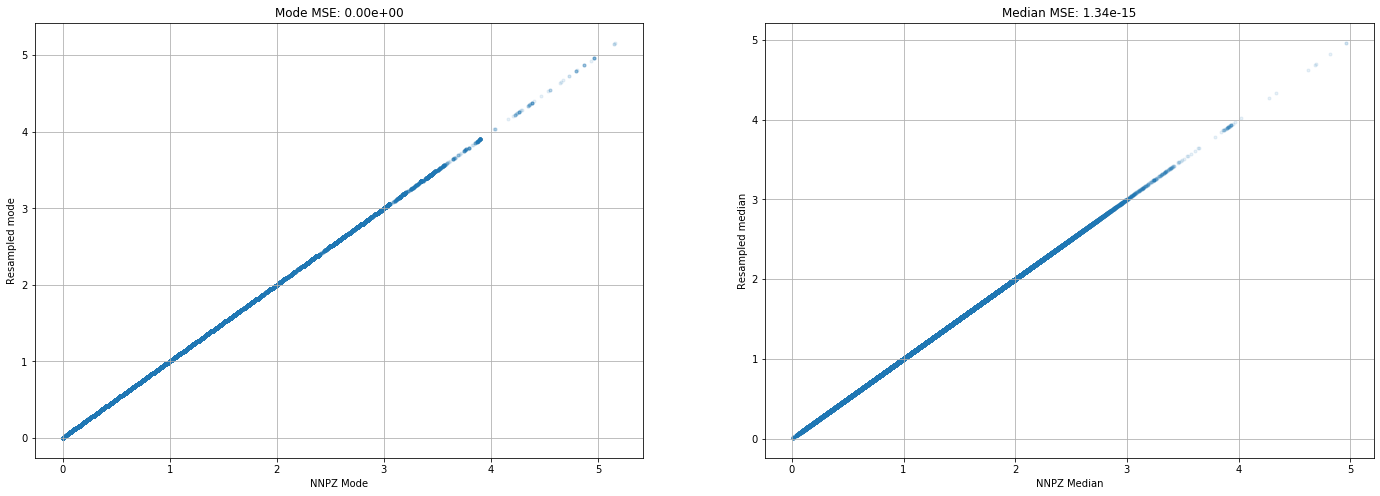

In [8]:
_ = plot_scatter(table['REDSHIFT_PDF'], pdz_bins)

## Naive rebinning

In [9]:
naive_pdz = pdz[:,1:].reshape(len(pdz), 300, -1).sum(axis=2)
naive_pdz[:, 0] += pdz[:, 0]
naive_pdz_sum = np.trapz(naive_pdz, out_pdz_bins, axis=1)
naive_pdz[:] = (naive_pdz[:].T / naive_pdz_sum).T

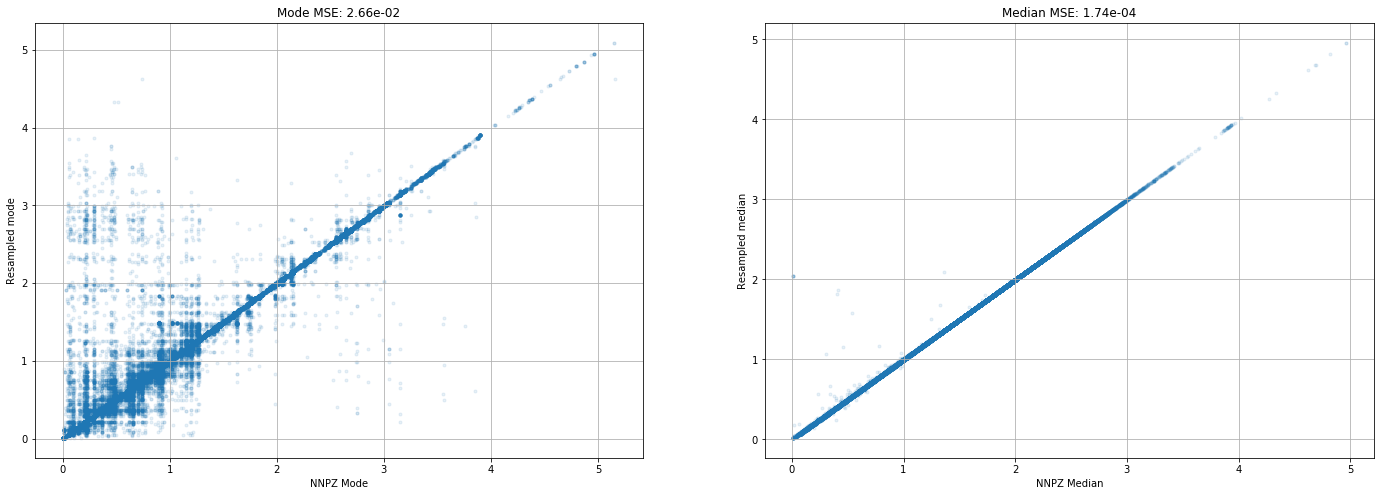

In [10]:
naive_pdz_modes, naive_pdz_median = plot_scatter(naive_pdz)

In [11]:
worst_offender = np.nanargmax(table['REDSHIFT_MODE'] - naive_pdz_modes**2)
print(worst_offender)

177746


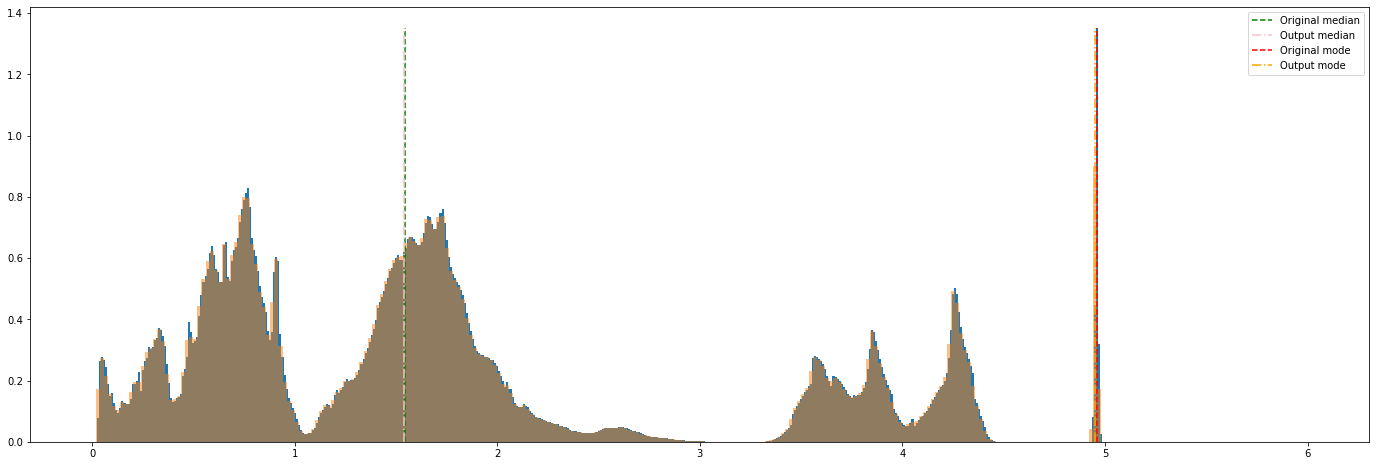

In [33]:
plot_pdz(pdz[worst_offender], naive_pdz[worst_offender])

## Simple interpolation

In [13]:
inter_pdz = np.zeros((len(pdz), len(out_pdz_bins)))

In [14]:
for i in range(len(pdz)):
    interpolated = interpolate.interp1d(pdz_bins, pdz[i])
    inter_pdz[i,:] = interpolated(out_pdz_bins)

/home/aalvarez/miniconda3/envs/phz/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


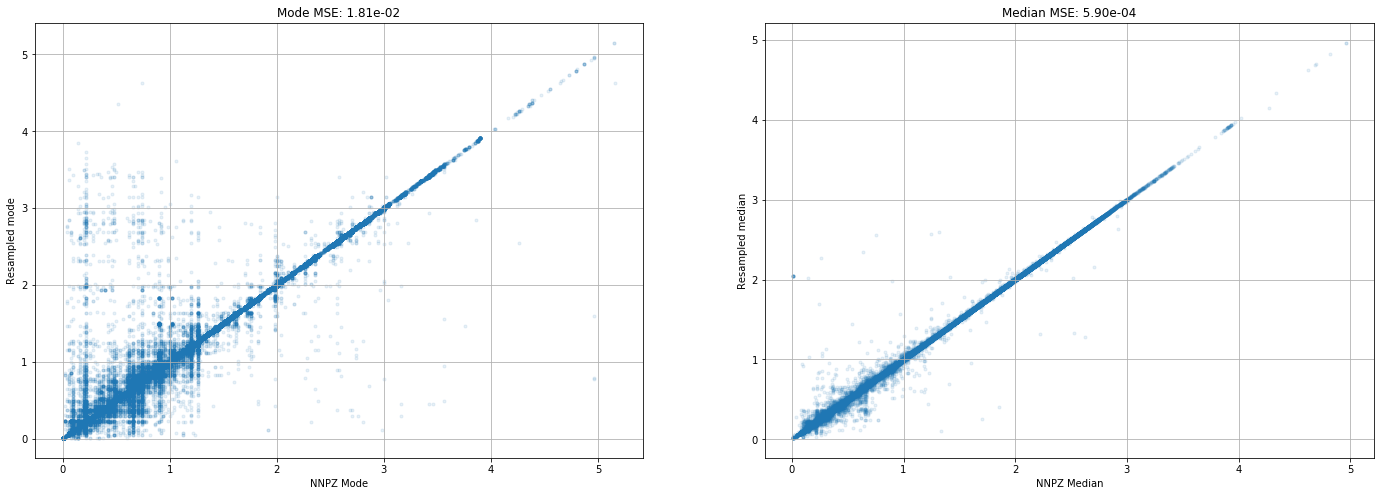

In [15]:
inter_pdz_mode, inter_pdz_median = plot_scatter(inter_pdz)

In [38]:
worst_offender = np.nanargmax((table['REDSHIFT_MODE'] - inter_pdz_mode)**2)
print(worst_offender)

29217


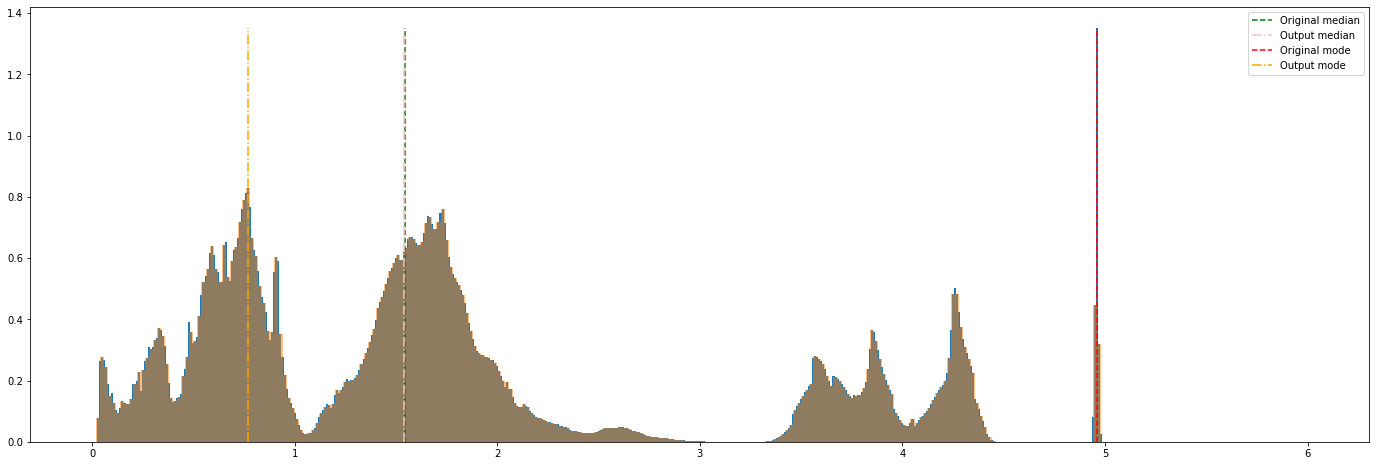

In [39]:
plot_pdz(pdz[worst_offender], inter_pdz[worst_offender])

## Interpolating via integral
The idea is:
- Interpolate the PDF
- Create bins (center-width/2, center+width/2)
- Integrate curve under that region for the value at center
- Normalize

In [18]:
via_area = np.zeros(inter_pdz.shape)
bin_width = (out_pdz_bins[1] - out_pdz_bins[0]) / 2.
pdz_bin_edges = np.stack([out_pdz_bins - bin_width, out_pdz_bins + bin_width]).T

for i in range(len(pdz)):
    interpolated = interpolate.interp1d(pdz_bins, pdz[i])
    via_area[i,:] = np.trapz(interpolated(pdz_bin_edges), pdz_bin_edges)
    via_area[i,:] /= np.trapz(via_area[i,:], out_pdz_bins)

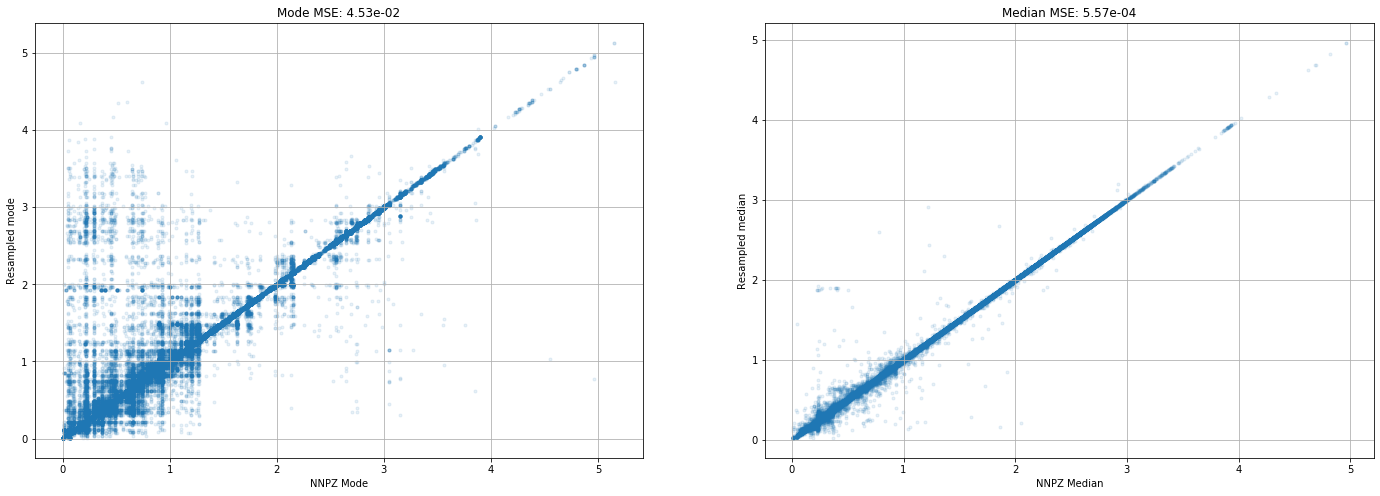

In [19]:
area_mode, area_median = plot_scatter(via_area)

In [40]:
worst_offender = np.nanargmax(table['REDSHIFT_MODE'] - area_mode)
print(worst_offender)

29217


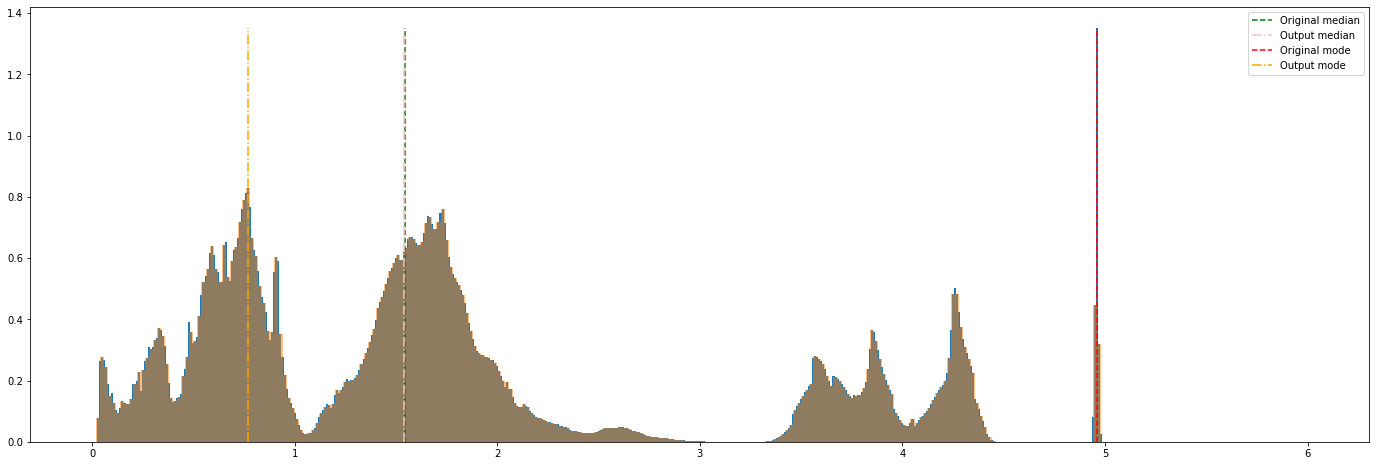

In [41]:
plot_pdz(pdz[worst_offender], inter_pdz[worst_offender])

## Max-based

In [22]:
max_pdz = pdz[:,1:].reshape(len(pdz), 300, -1).max(axis=2)
max_pdz[:, 0] = np.max([pdz[:, 0], max_pdz[:,0]], axis=0)
max_pdz_sum = np.trapz(max_pdz, out_pdz_bins, axis=1)
max_pdz[:] = (max_pdz[:].T / max_pdz_sum).T

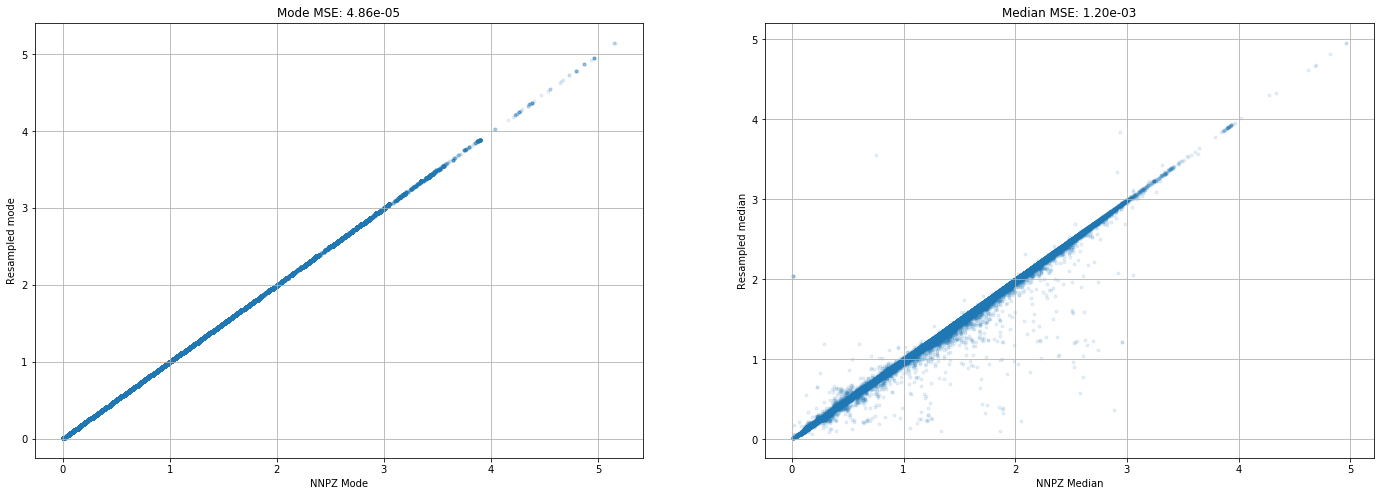

In [23]:
max_pdz_mode, max_pdz_median = plot_scatter(max_pdz)

In [42]:
worst_offender = np.nanargmax(table['REDSHIFT_MODE'] - max_pdz_mode)
print(worst_offender)

588


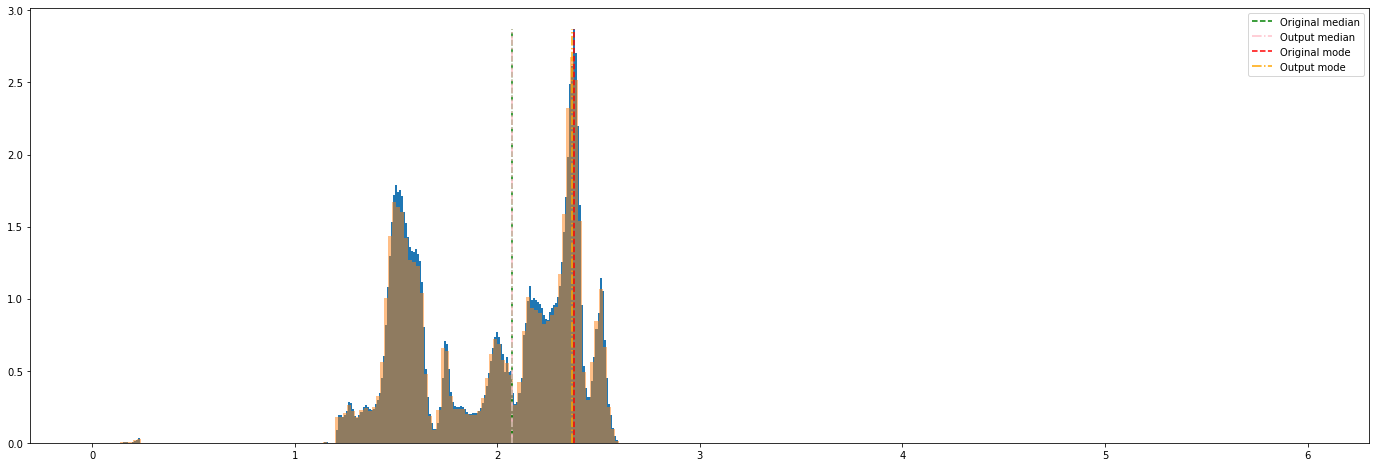

In [43]:
plot_pdz(pdz[worst_offender], max_pdz[worst_offender])

## MC mode

In [26]:
import scipy.stats

In [27]:
bin_width = (pdz_bins[1] - pdz_bins[0]) / 2.
pdz_bin_edges = np.append((pdz_bins - bin_width), pdz_bins[-1]+bin_width)

In [28]:
scipy_hist_pdz = np.zeros(inter_pdz.shape)
for i in range(len(pdz)):
    rv_hist = scipy.stats.rv_histogram((pdz[i], pdz_bin_edges))
    scipy_hist_pdz[i, :] = rv_hist.pdf(out_pdz_bins)

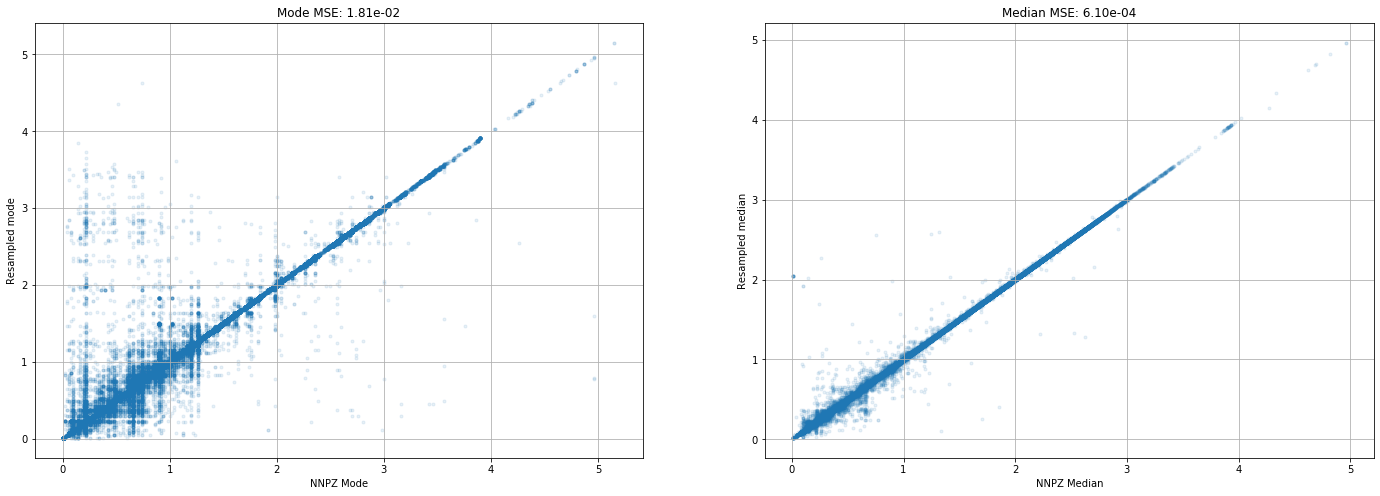

In [29]:
scipy_hist_pdz_mode, scipy_hist_pdz_median = plot_scatter(scipy_hist_pdz)

In [44]:
worst_offender = np.nanargmax(table['REDSHIFT_MODE'] - scipy_hist_pdz_mode)
print(worst_offender)

29217


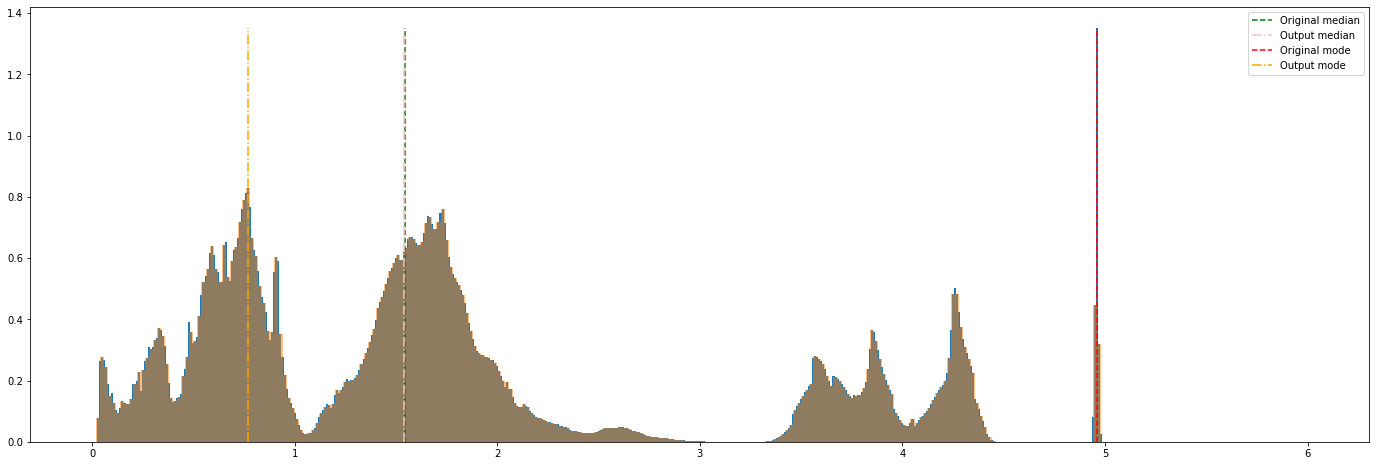

In [45]:
plot_pdz(pdz[worst_offender], scipy_hist_pdz[worst_offender])